<center>
<h3><b>EXPLORATION DATA ANALYSIS OF SUICIDE RATE IN SINGAPORE</b></h3>
</center>                                                                                   

<p style="
            font-size:12px; 
            float: right;
            margin: 20px;">CM2015: PROGRAMMING WITH DATA</p>

### **Table of Content**

- [1.0 Introduction](#10-introduction)
    - [1.1 Background](#11-background)
    - [1.2 Aims and Objectives](#12-aims-and-objectives)


- [2.0 Data Preparation](#20-data-preparation)
    - [2.1 Data Requirements](#21-data-requirements)
    - [2.2 Supplement Data](#22-supplement-data)
    - [2.3 Data Preprocessing and Exploratory Data Analysis (EDA)](#23-data-preprocessing-and-exploratory-data-analysis-eda)

- [3.0 Results and Discussion](#30-results-and-discussion) 
    - [3.1 Key-Findings](#31-key-findings)
    - [3.2 Limitations](#32-limitations)
    - [3.3 Conclusion](#33-conclusion)
<br>
- [4.0 References and Resources](#40-references-and-resources)

In [1]:
# pip install -r requirements.txt

In [2]:
# import libraries & modules
import os, praw, nltk
import pandas as pd
import numpy as np
from dotenv import load_dotenv
from wordcloud import WordCloud
import seaborn as sns
import matplotlib.pyplot as plt

        # nltk.download('wordnet')
        # nltk.download('stopwords')
        # nltk.download('punkt')

from nltk import sent_tokenize, word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

# settings
dir = os.getcwd()
load_dotenv()

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', '{:.2f}'.format)

In [3]:
# reusable functions used within the project
def read_csv(file_name):
    return pd.read_csv(dir + '/dataset/' + file_name)

def remove_commas(value):
    try:
        return float(value.replace(',', ''))
    except ValueError as e:
        return np.nan
    
def print_info(df):
    print('Shape:', df.shape)
    print('\n')
    print(df.info())

def filter_data(df, mask=None):
    if mask is not None:
        df = df[mask]
    else:
        (df['year'] >= 2016) & (df['year'] <= 2021)
    
    check_null = df.isnull().sum().sum()
    print('Null values:', check_null)
    return df

def map_age(age):
    if age in ['5-14 years']:
        return '0-14 Years'
    elif age in ['15-24 years', '25-34 years', '35-54 years', '55-64 years']:
        return '15-64 years'
    elif age in ['65-74 years', '75+ years']:
        return '65 years & over'
    else:
        return 'Unknown'

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

filter_out = {'http', 'even', 'samaritan', 'singapore', 'however', 'also', 'many', 'would'}
stop_words.update(filter_out)

def process_text(text):
    words = word_tokenize(text)
    word_frequencies = {}

    for word in words:
        if word.isalpha() and len(word) > 3 and word.lower() not in stop_words:
            cleaned_word = lemmatizer.lemmatize(word.lower())
            word_frequencies[cleaned_word] = word_frequencies.get(cleaned_word, 0) + 1

    return word_frequencies

def plot_feature_distribution(df):
    df.hist(figsize=(25, 4), bins=15, layout=(1, len(df.columns)))
    plt.suptitle("feature distribution")
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) 
    plt.show()

def fill_na(df, column):
    df[column] = df[column].fillna(df[column].mean())
    return df

### **1.0 Introduction**

##### **1.1 Background**

<p style="font-size: 15px;">
While scrolling through the news, I chanced upon an<a href="https://www.channelnewsasia.com/singapore/suicides-reported-singapore-476-2022-highest-more-20-years-3597791"> article </a>that brings attention to the concerning surge in suicide rates in Singapore.</p>

<small>

> *The number of suicides last year was a "concerning rise" of 25.9 per cent from the 378 reported in 2021, SOS said in a media release, citing data from the Immigration and Checkpoints Authority. Suicide remained the leading cause of death for youths aged 10 to 29 for the fourth consecutive year – about a third of all deaths in this age group were suicides.* [[1]](#40-references-and-resources)
</small>

<center><img src="./assets/figure_1.png" width="600"/></center>
<center><p style="font-size: 13px;"><b>Figure 1.1</b>: Understanding the problem statement</p></center>




<p style="font-size: 15px;">
The contrast of significant distress in a highly developed, first-world society raises questions regarding the efficacy of existing mental health programs, prompting my curiosity, leading to an investigation into the foundational societal challenges arising from a variety of interrelated issues—an interplay of mental health, community support, societal pressures, and other social factors contributing to this phenomenon.


<p style="font-size: 15px;">
Before this, my preliminary literature review, including a study on a Reddit web crawler <a href="#40-references-and-resources">[2]</a> investigating common keywords associated with this topic reveals a gap in understanding the social factors contributing to these rising rates in Singapore. The Samaritans of Singapore (SOS), which stands as the only organization dedicated to suicide prevention in Singapore, is funded by the National Council of Social Service (NCSS) and the Community Chest, both of which are government-affiliated entities and the infographic above was adapted from the Samaritans of Singapore Financial Year 2021-2022 annual report <a href="#40-references-and-resources">[3]</a>. A considerable majority of the issues are psychological. However, it is important to consider the following paragraph from the report: 'For calls with suicidal risk, common problems include employment, financial difficulties, inability to cope with current crises, family relationships, and boy-girl relationship problems.' A number of these concerns can be categorized under social problems. 

<p style="font-size: 15px;">
While there have been studies on suicide rates globally, this research particularly focuses on the interplay of social factors and government interventions within Singapore's specific socio-economic context. The approach of integrating data analysis with public sentiment and initiatives evaluation fills a gap in existing literature, particularly in comprehending how these factors interact in a first-world Asian society. 

##### **1.2 Aims and Objectives**

> **Question**: What are the major social determinants contributing to the increasing suicide rates in Singapore, and how do these determinants interact with the Samaritans of Singapore (SOS) intervention?


<p style="font-size: 15px;">
The research primarily focuses on investigating the social factors contributing to the increase in suicide rates in Singapore, one of the few developed Southeast Asian countries. The findings are targeted at providing key insights for enhancing mental health strategies and shaping suicide prevention initiatives.</p>

<p style="font-size: 15px;">
Within this project, I would like to explore the following: </p>

<ul>
    <li style="font-size: 15px;"><b>Understanding the research question</b>:
        <ul>
            <li style="font-size: 15px;">Identifying the range of social risk factors</li>
            <li style="font-size: 15px;">Exploring suicide prevention initiatives</li>
            <li style="font-size: 15px;">Evaluating theAYBE effectiveness of government efforts</li>
        </ul>
    </li>
    <li style="font-size: 15px;"><b>Analysing perspectives on preventive measures</b>:
        <ul>
            <li style="font-size: 15px;">Public sentiment analysis</li>
            <li style="font-size: 15px;">Keyword analysis in public discussions</li>
        </ul>
    </li>
    <li style="font-size: 15px;">Examining the relationships between social risk factors to illustrate the correlations and impact.</li>
</ul>

<p style="font-size: 15px;">
For this project proposal, I aim to:
<ul>
    <li style="font-size: 15px; list-style-type: none;">(1) Determine the optimal amount of data required to thoroughly investigate the identified questions, considering constraints on time and resources.</li> 
    <li style="font-size: 15px; list-style-type: none;">(2) Extract data using third-party APIs and web scraping, storing it in a format suitable for subsequent data cleaning and analysis.</li>
    <li style="font-size: 15px; list-style-type: none;">(3) Prepare the data through feature engineering, creating new variables from existing ones and addressing any missing or incorrect values.</li>
    <li style="font-size: 15px; list-style-type: none;">(4) Conduct comprehensive exploratory data analysis to reveal trends and patterns within the dataset, focusing on both social risk factors and the impact of suicide prevention initiatives.</li>
    <li style="font-size: 15px; list-style-type: none;">(5) Investigate the relationships between numerous social risk factors and suicide rates, and evaluate the correlation and potential causal links between these factors and suicide prevention initiatives.</li>
    <li style="font-size: 15px; list-style-type: none;">(6) Analyze the data to evaluate the effectiveness of suicide prevention initiatives.</li>
    <li style="font-size: 15px; list-style-type: none;">(7) Utilize natural language processing techniques to analyze public discussions from Reddit, and analyze the words to create a visually informative word cloud. </li>
    <li style="font-size: 15px; list-style-type: none;">(7) Conclude on my findings and provide insights on the research question.</li>
</ul>

<p style="font-size: 15px;">
The focus of the project will remain on Singapore’s distinctive socio-economic environment. It will be limited to researching social risk factors, public sentiment, and suicide prevention initiatives related to mental health within Singapore. Due to limited resources and time, the policies-related data will only come from the Samaritans of Singapore (SOS) and other aspects such as clinical psychology, psychiatry, or comparisons with suicide rates in other countries shall not be covered in the analysis.

##### **2.0 Data Preparation**

<table style="font-size: 15px; border-collapse: collapse;">
    <tr style="border: none;">
        <th align="left" style="border: none;"></th>
        <th align="left" style="border: none;">Name</th>
        <th align="left" style="border: none;">Format</th>
        <th align="left" style="border: none;">Source</th>    
        <th align="left" style="border: none;">Link</th>  
    </tr>
    <tr style="border: none;">
        <td align="left" style="border: none;">1</td>
        <td align="left" style="border: none;"><b>[MAIN]</b> Suicide Rates Overview (1985 to 2021)</td>
        <td align="left" style="border: none;">CSV</td>
        <td align="left" style="border: none;">United Nations Development Program (HDI data), World Bank (GDP data), WHO (suicide prevention data)</td>
        <td align="left" style="border: none;"><a href="https://www.kaggle.com/datasets/omkargowda/suicide-rates-overview-1985-to-2021/data">🔗</a></td>
    </tr>
    <tr style="border: none;">
        <td align="left" style="border: none;">2</td>
        <td align="left" style="border: none;">Hospital Admission Rate by Age and Sex</td>
        <td align="left" style="border: none;">CSV</td>
        <td align="left" style="border: none;">Ministry of Health (MOH)</td>
        <td align="left" style="border: none;"><a href="https://beta.data.gov.sg/collections/511/view">🔗</a></td>
    </tr>
    <tr style="border: none;">
        <td align="left" style="border: none;">3</td>
        <td align="left" style="border: none;">Number of Long-Term Unemployed Residents, Annual</td>
        <td align="left" style="border: none;">CSV</td>
        <td align="left" style="border: none;">Ministry of Manpower (MOM)</td>
        <td align="left" style="border: none;"><a href="https://beta.data.gov.sg/collections/656/view">🔗</a></td>
    </tr>
    <tr style="border: none;">
        <td align="left" style="border: none;">4</td>
        <td align="left" style="border: none;">Samaritans of Singapore (SOS) Literature Review (2016 to 2021)</td>
        <td align="left" style="border: none;">PDF</td>
        <td align="left" style="border: none;">Samaritans of Singapore (SOS)</td>
        <td align="left" style="border: none;"><a href="https://www.sos.org.sg/media/annual-reports">🔗</a></td>
    </tr>
        <tr style="border: none;">
        <td align="left" style="border: none;">5</td>
        <td align="left" style="border: none;">Public Opinion on Samaritans of Singapore (SOS)</td>
        <td align="left" style="border: none;">Web API to List</td>
        <td align="left" style="border: none;">Reddit</td>
        <td align="left" style="border: none;"><a href="https://www.reddit.com/r/singapore/">🔗</a></td>
    </tr>
</table>

##### **2.1 Data Requirements**
<p style="font-size: 15px;">
I chose these datasets because they fulfill the requirements for assessing the major social factors contributing to increasing suicide rates in Singapore and their interaction with suicide prevention initiatives by offering comprehensive information on the direct indicators of the problem (suicide rates) and social factors (mental health issues, economic stress, community support, etc) and government efforts (healthcare availability and investment, etc). Each dataset contributes a critical piece of information that, when evaluated together, can provide a view of the factors driving suicide rates in Singapore. 

<p style="font-size: 15px;">
<b>1. Suicide Rates Overview (1985 to 2021)</b>

<p style="font-size: 15px;">
<b>Source(s):</b> Kaggle—the original <a href="https://www.kaggle.com/datasets/russellyates88/suicide-rates-overview-1985-to-2016">dataset</a>, which compiled data from four other datasets linked by time and place, was created to identify signals correlated to increased suicide rates among different cohorts globally, across the socio-economic spectrum. <a href="#40-references-and-resources">[4]</a> Data were compiled from reputable international sources and the aggregated dataset is available on Kaggle:

<ul>
    <li style="font-size: 15px;"><b>References</b>:
        <ul>
            <li style="font-size: 15px;">United Nations Development Program. (2018). Human development index (HDI). Retrieved from http://hdr.undp.org/en/indicators/137506</li>
            <li style="font-size: 15px;">World Bank. (2018). World development indicators: GDP (current US$) by country:1985 to 2016. Retrieved from http://databank.worldbank.org/data/source/world-development-indicators</li>
            <li style="font-size: 15px;">[Szamil]. (2017). Suicide in the Twenty-First Century [dataset]. Retrieved from https://www.kaggle.com/szamil/suicide-in-the-twenty-first-century/notebook</li>
            <li style="font-size: 15px;">World Health Organization. (2018). Suicide prevention. Retrieved from http://www.who.int/mental_health/suicide-prevention/en/</li>
        </ul>
    </li>
</ul>

In [4]:
# suicide rate dataset
main_df = read_csv('main.csv')
print(main_df.columns.tolist())

['country', 'year', 'sex', 'age', 'suicides_no', 'population', 'suicides/100k pop', 'country-year', 'HDI for year', ' gdp_for_year ($) ', 'gdp_per_capita ($)', 'generation']


<p style="font-size: 15px;">
<b>Relevance:</b> I have selected this dataset as my primary source because it provides insights into suicide rates, along with social and socio-economic indicators, such as the Human Development Index (HDI) and Gross Domestic Product (GDP), which allows for an in-depth analysis of the relationship between economic development and mental health outcomes, highlighting the impact of socio-economic environments on suicide rates. Although the dataset extends only up to 2021, leaving a gap for 2022-2023, it is still an invaluable tool for analysis given the limited data available on this subject. However, since the dataset includes global data, it is necessary to filter out data irrelevant to our study, focusing specifically on Singapore to address our research question.

<p style="font-size: 15px;">
<b>Ethical Consideration and Implications of using data for research:</b> The dataset is openly distributed on Kaggle and compiled from multiple authoritative sources, including the World Health Organization, World Bank, and United Nations Development Program, which provides credibility to the information within the dataset. The license for this dataset is the CC0 Public Domain license, indicating that it is open-source and available for use, allowing others to build upon and use the dataset meaningfully. 

<small>

> *As stipulated in the creative commons terms, CC0 enables scientists, educators, artists and other creators and owners of copyright- or datamain_df-protected content to waive those interests in their works and thereby place them as completely as possible in the public domain, so that others may freely build upon, enhance and reuse the works for any purposes without restriction under copyright or datamain_df law. The person who associated a work with this deed has dedicated the work to the public domain by waiving all of his or her rights to the work worldwide under copyright law, including all related and neighboring rights, to the extent allowed by law.* <a href="#40-references-and-resources">[5]</a></small>

<p style="font-size: 15px;">
When handling the sensitive nature of confidential information, such as suicide data, detected identifiers will be anonymized and removed to protect individual privacy and prevent accidental defamation of the deceased. Under section 499 of the Penal Code, it is an offence to defame a person, even if they are deceased <a href="#40-references-and-resources">[6]</a>. Consequently, our approach must be careful, avoiding any erroneous assumptions or sweep generalizations that could stigmatize individuals or groups which highlights the importance for our analysis to be conducted with fairness, ensuring that it does not accidentally contribute to discrimination or reinforce negative stereotypes, particularly when analyzing data across various socio-economic or demographic categories.

<p style="font-size: 15px;">
<b>Data processing pipeline considerations:</b> Transparency was properly accounted for in all processes: from data collection, cleaning, and transformation, to findings and proper attribution. Every step of the way was well-documented with my rationale and logic behind each step, ensuring that the dataset was used responsibly.

<p style="font-size: 15px;">
<b>Other Dataset(s) considerations:</b> 
<ul>
    <li style="font-size: 15px;"><a href="https://www.who.int/data/gho/data/themes/mental-health/suicide-rates">World Health Organization (WHO)'s Suicide Data</a></li>
    <ul>
    <li style="font-size: 15px;">The dataset offers a worldwide perspective but lacks the socio-economic context necessary for aligning with our research question. However, since we are not considering a comparison of statistics with other countries, I have decided not to proceed with this dataset. Instead, I used a composite dataset on Kaggle that combines this primary dataset with other datasets from reliable sources, offering a more comprehensive socio-economic data and allowing for an in-depth analysis of our study.
    </ul>
    <li style="font-size: 15px;"><a href="https://ourworldindata.org/suicide?insight=-strong-suicide-rates-vary-around-the-world-strong-#key-insights-on-suicide">Our World in Data's Suicide Data</a></li>
    <ul>
    <li style="font-size: 15px;">This data offers a worldwide perspective that could be valuable in feature engineering. However, it lacks the relevant data needed to correlate with my research question. Furthermore, the dataset and article seem to focus more on clinical psychology and mental health, areas I have stated will not be covered in my analysis.
    </ul>

##### **2.2 Supplement Data**

<p style="font-size: 15px;">
<b>2. Suicide Rate Supplement Data</b>
<ul>
    <li style="font-size: 15px;"><a href="https://beta.data.gov.sg/collections/511/view">Hospital Admission Rate by Age and Sex</a></li>
    <ul>
    <li style="font-size: 15px;"><b>Source(s):</b> Ministry of Health (MOH)</li>    
    <li style="font-size: 15px;"><b>Relevance:</b> Admission rates to psychiatric facilities are a direct measure of mental health issues in the population, making this dataset highly relevant to understanding one of the critical psychosocial factors—mental health. With access to the demographic data, the dataset could prove useful in the analysis of mental health trends and patterns within the population, facilitating the evaluation of the prevalence of mental health conditions and the degree of government/community involvement with mental health services, which is evident in its potential to delve into the analysis of psychiatric hospital admissions categorized by age and sex. From such analysis, we can extract valuable insights from key indicators that are reflective of the scale of mental health challenges prevalent in the community. However, despite its significance, this dataset will not be the central element of my research as stated above because my investigation primarily leans towards exploring social factors rather than delving into the wider aspects of mental health.
    <li style="font-size: 15px;"><b>Ethical Consideration and Implications of using data for research:</b> This dataset is labeled under the Singapore Open Data License, which indicates that it is open-source and publicly accessible to be freely used as developers see fit. The provenance from official government sources suggests high reliability. Reusing data makes it possible to reproduce studies, generate new research questions and new knowledge, but it also gives rise to technical and ethical challenges. Part of these issues are repositories interoperability to accomplish fair principles or issues related to data privacy or anonymity. <a href="#40-references-and-resources">[7]</a> Healthcare data, especially those related to suicide, must be handled with utmost confidentiality through anonymization. Derived conclusions must be presented in a fair and just manner to avoid harmful assumptions about specific demographics that will incur discourse.</li>
    <li style="font-size: 15px;"><b>Data processing pipeline considerations:</b> Transparency was properly accounted for in all processes: from data collection, cleaning, and transformation, to findings and proper attribution. Every step of the way was well-documented with my rationale and logic behind each step, ensuring that the dataset was used responsibly.
    </ul>
</ul>

<p style="font-size: 15px;">
<b>3. Social Determinants Data</b>
<ul>
    <li style="font-size: 15px;"><a href="https://beta.data.gov.sg/collections/656/view">Number of Long-Term Unemployed Residents, Annual</a></li>
    <ul>
        <li style="font-size: 15px;"><b>Source(s):</b> Ministry of Manpower (MOM)—the data comes from the Labour Force Survey, Manpower Research & Statistics Department, MOM, except data for June 1995, and June 2005, which are from the General Household Surveys 1995 & 2005 conducted by Department of Statistics, Ministry of Trade and Industry.</li>    
        <li style="font-size: 15px;"><b>Relevance:</b> With reference to figure 1.1, quoting the sentence 'For calls with suicidal risk, common problems include employment, financial difficulties, inability to cope with current crises, family relationships, and boy-girl relationship problems.', indicates that employment is one of the socio-economical factors with the potential to incite suicidal tendencies. The age adjusted odds ratios (95% confidence intervals) of death by suicide among 25 to 64 year olds who were unemployed compared with employed were 2.46 (1.10 to 5.49) for women and 2.63 (1.87 to 3.70) for men. Similarly increased odds ratios were observed for the non-active labour force compared with the employed. Strong age only adjusted associations of suicide death with the socioeconomic factors of education (men only), car access, and household income were observed. Compared with those who were married on census night, the non-married had odds ratios of suicide of 1.81 (1.22 to 2.69) for women and 2.08 (1.66 to 2.61) for men. In a multivariable model the association of socioeconomic factors with suicide reduced to the null. However, marital status and labour force status remained strong predictors of suicide death. Unemployment was also strongly associated with suicide death among 18–24 year old men. Sensitivity analyses suggested that confounding by mental illness might explain about half, but not all, of the association between unemployment and suicide. Being unemployed was associated with a twofold to threefold increased relative risk of death by suicide, compared with being employed. <a href="#40-references-and-resources">[8]</a></li>
        <li style="font-size: 15px;"><b>Ethical Consideration and Implications of using data for research:</b> This dataset is labeled under the Singapore Open Data License, which indicates that it is open-source and publicly accessible to be freely used as developers see fit. A portion of the data was gathered from the Labour Force Survey, in which 
        participants voluntarily gave consent to external data usage. The dataset has been anonymized to prevent the identification of any unemployed individuals and to address privacy concerns.</li>
        <li style="font-size: 15px;"><b>Data processing pipeline considerations:</b> Transparency was properly accounted for in all processes: from data collection, cleaning, and transformation, to findings and proper attribution. Every step of the way was well-documented with my rationale and logic behind each step, ensuring that the dataset was used responsibly.</li>
    </ul>
    <li style="font-size: 15px;"><a href="https://www.sos.org.sg/media/annual-reports">Samaritans of Singapore (SOS) Literature Review (2016 to 2021)</a></li>
    <ul>
        <li style="font-size: 15px;"><b>Source(s):</b> Samaritans of Singapore (SOS), a non-profit, non-religious organization which focuses on crisis intervention and suicide prevention. I will manually extract data from their annual reports, covering the period from 2016 to 2021 only, to create a dataframe that compiles data over time. This process involves identifying relevant sections, such as statistics on incoming calls, the number of outreach programs within the year etc, and transcribing this information into a structured format for further analysis.</li>    
        <li style="font-size: 15px;"><b>Relevance:</b> The data is highly relevant since my research focuses on investigating the interactions between social factors that cause suicide and how the Samaritans of Singapore intervene. The annual report provides the number of initiatives, outreach programs, and other important information indicative of community engagement and the demand for support services while offering specific metrics that can be directly correlated with broader social determinants and suicide rates.</li>
        <li style="font-size: 15px;"><b>Ethical Consideration and Implications of using data for research:</b> The information retrieved from the annual report should be anonymized, including testimonials that might reveal identities, to respect the dignity and privacy of individuals who have interacted with the Samaritans of Singapore. This applies even with voluntary consent, as the data will be aggregated for further analysis that could potential yield undesired, deeper insights. The purpose of retrieving information from an annual report is not to discover patterns that could stigmatize individuals or groups of people, but rather to answer the research question, which aims to improve the enforcement of social initiatives and support. </li>
        <li style="font-size: 15px;"><b>Data processing pipeline considerations:</b> The extraction of data from the annual reports will be a manual process involving tabulation and aggregation to convert it into a structured CSV format, which will subsequently be processed into a dataframe. As this approach is mostly manual, it will be necessary to pay meticulous attention to detail to prevent any tabulation errors. The procedure will consist of a detailed review of each segment of the reports to ensure the data's accuracy and completeness.
        </li>
    </ul>
    <p style="font-size: 15px;">
<b>4. Samaritans of Singapore (SOS) Data</b>
<ul>
    <li style="font-size: 15px;"><a href="https://www.reddit.com/r/singapore/">Singaporeans' perception on Samaritans of Singapore (SOS)</a></li>
    <ul>
    <li style="font-size: 15px;"><b>Source(s):</b> Reddit, a social media platform for discussions. I will be using the PRAW Python library to extract specific topics related to Samaritans of Singapore (SOS).</li>    
    <li style="font-size: 15px;"><b>Relevance:</b> Reddit is particularly well-suited for conducting qualitative analysis of public sentiment, which can reflect public perception, experiences, and attitudes toward the efficacy of existing initiatives and their dedicated efforts in suicide intervention. The data is highly relevant to my research, as my objective includes assessing the effectiveness of the Samaritans of Singapore's campaigns and their interaction with social factors. By incorporating the public's perspective and sentiment into the analysis, it will facilitate the discovery of feedback that gauges the effectiveness of these campaigns.
    <li style="font-size: 15px;"><b>Ethical Consideration and Implications of using data for research:</b> While Reddit content is publicly available, ethical considerations still require anonymizing user data, as we are only collecting forum discussions to measure sentiment towards the Samaritans of Singapore. Reddit operates under the principle of fair use, a legal doctrine permitting the use of copyrighted material without the owner's consent under specific conditions. Uses that are “transformative,” in that they do not substitute for the original but instead add new and different meaning, message, or purpose to the original, are more likely to be “fair use.” <a href="#40-references-and-resources">[9]</a> However, we must consider potential biases, such as the majority of Reddit users tending to be under 40 years of age, which does not entirely represent the older population, even though they are included in the suicide rates demographic, or Reddit's discussion only reflecting opinions of the vocal majority which could potentially overlook the prespectives of the less vocal Singaporeans. The data retrieved could be biased in terms of age and tech-savviness.
    </li>
    <li style="font-size: 15px;"><b>Data processing pipeline considerations:</b> After scraping, the data will be structured into a format suitable for word cloud development, such as a list. All steps in the data collection, cleaning, and analysis processes will be clearly documented. I will select the criteria to filter out unwanted comments and transform them such that they are ready for analysis.
    </ul>
</ul>

</ul>

In [5]:
# data.gov.sg
hospital_admission_df = read_csv('hospital_admission.csv')
umemployment_df = read_csv('unemployment.csv')

# literature review
data = {
    "Year": [2016, 2017, 2018, 2019, 2020, 2021],
    "24-hour Hotline": [35832, 33604, 30896, 40889, 45746, 53692],
    "Calls with Sucide Risk": [6250, 6084, 6751, 6982, 9565, 14031],
    "Social Risk Factor(%)": [26, 26, 24, 26, 26, 24],
    "Outreach to Suicide Survivors": [109, 118, 124, 139, 132, None],
    "Community Outreach": [39, 22, 41, 37, 46, 67],
}

annual_report_df = pd.DataFrame(data)

# samaritans of singapore reddit data
word_cloud_data = []

params = praw.Reddit(
    client_id=os.getenv('CILENT_ID'), 
    client_secret=os.getenv('CILENT_SECRET'), 
    user_agent=os.getenv('USER_AGENT')
)

sub_reddit = params.subreddit('singapore')

for post in sub_reddit.search('Samaritans of Singapore', limit=200): 
    word_cloud_data.append(post.title)
    word_cloud_data.append(post.selftext)

##### **2.3 Data Preprocessing and Exploratory Data Analysis (EDA)**

<p style="font-size: 15px;">
Before proceeding with data processing, let's first review each of our datasets to cater them to our use case: retrieving only data pertaining to Singapore. After preparing the data, I will proceed to explore the correlation between social determinants and suicide rates in Singapore, which will be part of the exploratory data analysis (EDA) phase, during which I will use a variety of visualizations to better understand their relationships. This approach will aid in identifying patterns and trends, thereby enabling a comprehensive understanding of the data and generation of new knowledge.

<p style="font-size: 15px;">
<b>1. Suicide Rates Overview (1985 to 2021)</b>

<p style="font-size: 15px;">
In order to analyze the correlation between Gross Domestic Product (GDP) and suicide rates, it's necessary to convert its existing object format to float64 which involves removing regular expressions like commas to facilitate data processing.

In [6]:
main_df.head()

,country,year,sex,age,suicides_no,population,suicides/100k pop,country-year,HDI for year,gdp_for_year ($),gdp_per_capita ($),generation
0,Albania,1987,male,15-24 years,21.00,312900,6.71,Albania1987,NaN,"2,15,66,24,900",796.00,Generation X
1,Albania,1987,male,35-54 years,16.00,308000,5.19,Albania1987,NaN,"2,15,66,24,900",796.00,Silent
2,Albania,1987,female,15-24 years,14.00,289700,4.83,Albania1987,NaN,"2,15,66,24,900",796.00,Generation X
3,Albania,1987,male,75+ years,1.00,21800,4.59,Albania1987,NaN,"2,15,66,24,900",796.00,G.I. Generation
4,Albania,1987,male,25-34 years,9.00,274300,3.28,Albania1987,NaN,"2,15,66,24,900",796.00,Boomers


In [7]:
print_info(main_df)

Shape: (31756, 12)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31756 entries, 0 to 31755
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   country             31756 non-null  object 
 1   year                31756 non-null  int64  
 2   sex                 31756 non-null  object 
 3   age                 31756 non-null  object 
 4   suicides_no         30556 non-null  float64
 5   population          31756 non-null  int64  
 6   suicides/100k pop   31756 non-null  float64
 7   country-year        31756 non-null  object 
 8   HDI for year        12300 non-null  float64
 9    gdp_for_year ($)   31756 non-null  object 
 10  gdp_per_capita ($)  31756 non-null  float64
 11  generation          31756 non-null  object 
dtypes: float64(4), int64(2), object(6)
memory usage: 2.9+ MB
None


In [8]:
# data preprocessing
main_df[' gdp_for_year ($) '] = main_df[' gdp_for_year ($) '].apply(remove_commas)

mask = (main_df['country'] == 'Singapore') & \
       (main_df['year'] >= 2016) & (main_df['year'] <= 2021)

main_df = filter_data(main_df, mask)

main_df['age'] = main_df['age'].apply(map_age)
main_df = main_df[['year', 'sex', 'age', 'population', 'suicides/100k pop', ' gdp_for_year ($) ']]

main_df['suicides/100k pop'] = main_df['suicides/100k pop'].fillna(main_df['suicides/100k pop'].mean())

Null values: 0


In [9]:
main_df.head()

,year,sex,age,population,suicides/100k pop,gdp_for_year ($)
27887,2020,male,0-14 Years,5685807,0.05,340000000000.00
27969,2019,male,0-14 Years,5703569,0.05,374000000000.00
28051,2018,male,0-14 Years,5638676,0.02,376000000000.00
28133,2017,male,0-14 Years,5612253,0.00,343000000000.00
28215,2020,male,15-64 years,5685807,0.40,340000000000.00


<p style="font-size: 15px;">
Upon examination of the dataset, I discovered  a discrepancy: it extends only to 2020, although the title indicates coverage until 2021. Despite this, I've decided to retain the 2021 data in other datasets, as it has proven valuable, particularly in the context of the Samaritans of Singapore's literature review. This data becomes especially relevant when considering the spike in covid-19 cases beginning in 2020. There may be a connection between the pandemic lockdown, a rise in unemployment, and an increase in calls related to suicide risk thus the 2021 data should be preserved for a comprehensive analysis.

In [10]:
main_df.describe()

,year,population,suicides/100k pop,gdp_for_year ($)
count,48.00,48.00,48.00,48.00
mean,2018.50,5660076.25,0.49,358250000000.00
std,1.13,36781.33,0.42,16976203620.41
min,2017.00,5612253.00,0.00,340000000000.00
25%,2017.75,5632070.25,0.19,342250000000.00
50%,2018.50,5662241.50,0.41,358500000000.00
75%,2019.25,5690247.50,0.62,374500000000.00
max,2020.00,5703569.00,1.71,376000000000.00


In [11]:
# median: median value of suicides/100k pop
main_aggregated_df = (main_df.groupby(['year'])['suicides/100k pop']
                    .agg(['median'])
                    .reset_index()
                   )

main_aggregated_df.head()

,year,median
0,2017,0.33
1,2018,0.45
2,2019,0.44
3,2020,0.43


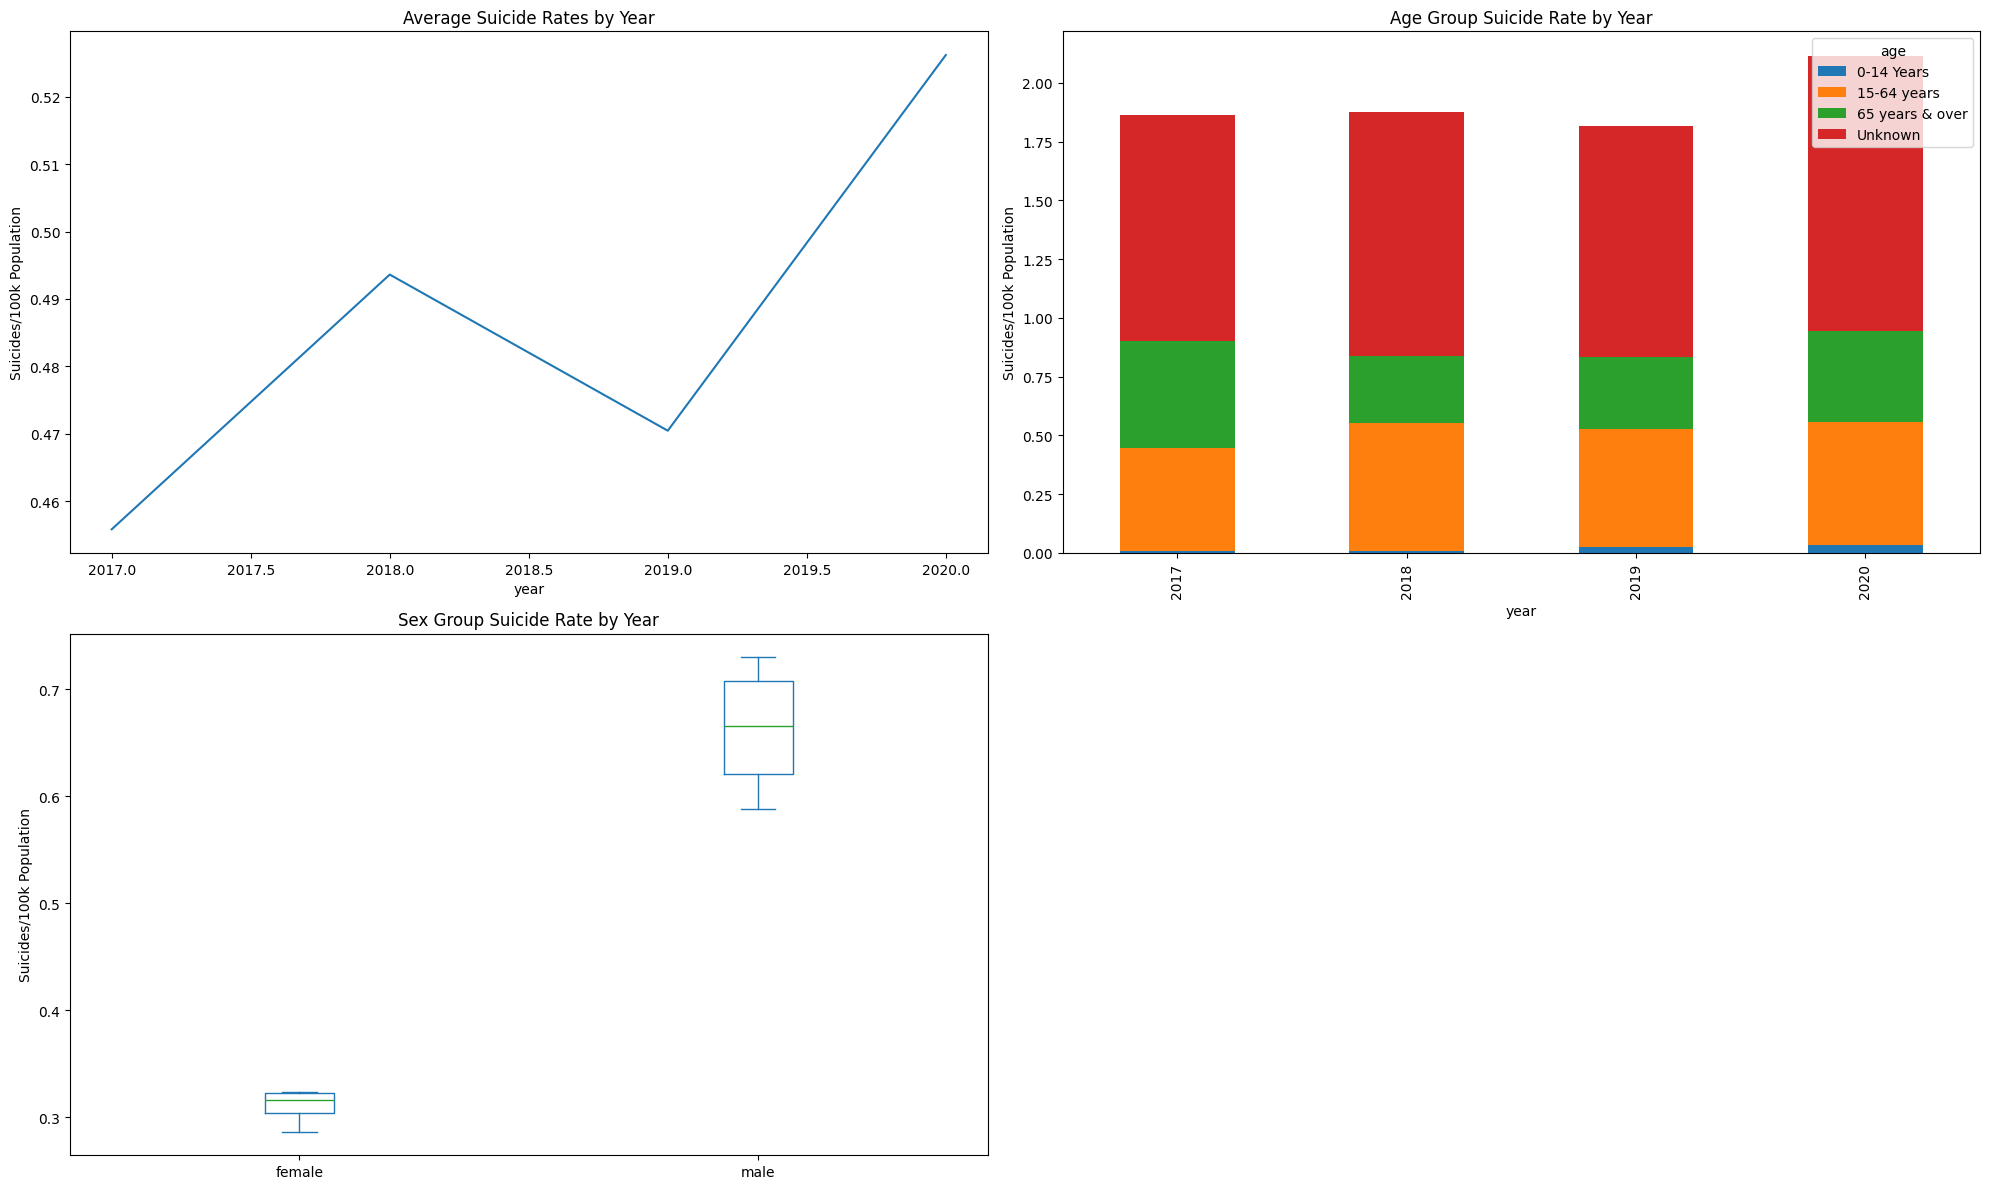

In [12]:
fig, axes = plt.subplots(2, 2, figsize=(20, 12))

# line graph
main_df.groupby('year')['suicides/100k pop'].mean().plot(kind='line', ax=axes[0, 0])
axes[0, 0].set_title('Average Suicide Rates by Year')
axes[0, 0].set_ylabel('Suicides/100k Population')

# stack bar chart
age = main_df.pivot_table(index='year', columns='age', values='suicides/100k pop')
age.plot(kind='bar', stacked=True, ax=axes[0, 1])
axes[0, 1].set_title('Age Group Suicide Rate by Year')
axes[0, 1].set_ylabel('Suicides/100k Population')

# box plot
sex = main_df.pivot_table(index='year', columns='sex', values='suicides/100k pop')
sex.plot(kind='box', ax=axes[1, 0])
axes[1, 0].set_title('Sex Group Suicide Rate by Year')
axes[1, 0].set_ylabel('Suicides/100k Population')

axes[1, 1].axis('off')
plt.tight_layout()
plt.show()

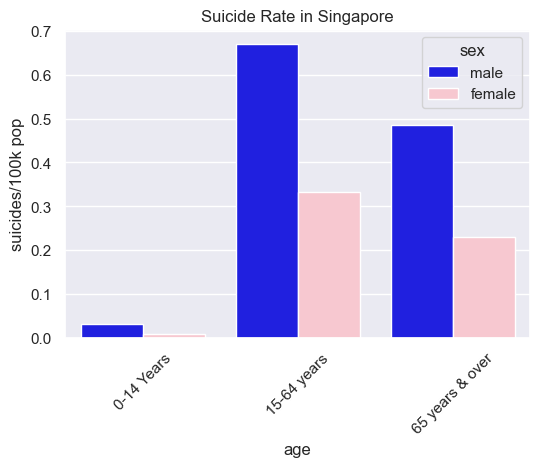

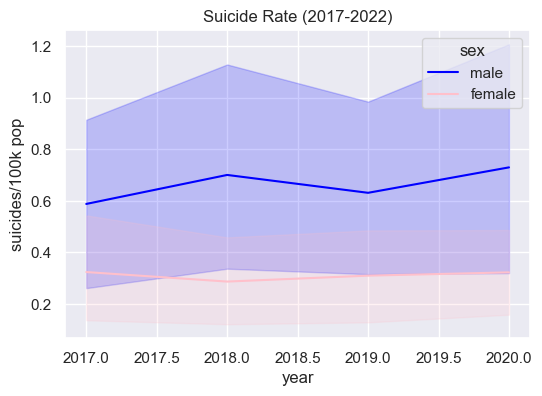

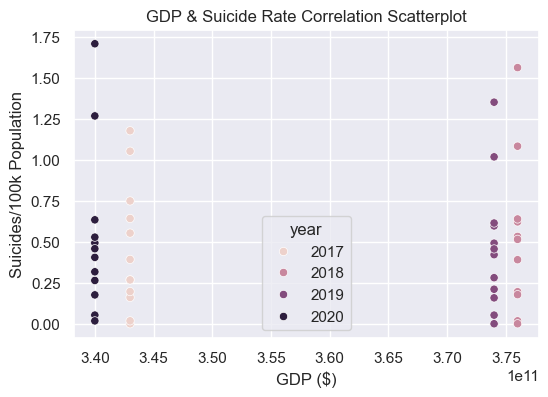

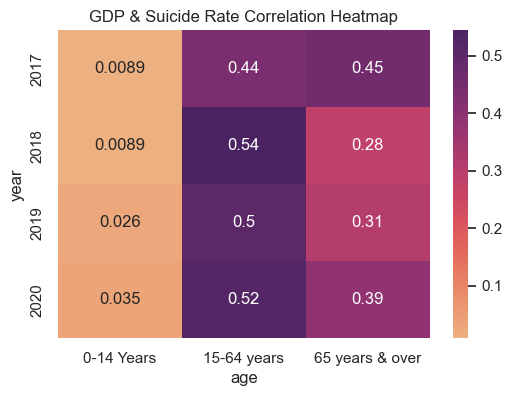

In [13]:
sns.set()

colour_palette = {'male': 'blue', 'female': 'pink'}
age_order = ['0-14 Years', '15-64 years', '65 years & over']
main_df['age'] = pd.Categorical(main_df['age'], categories=age_order, ordered=True)

# bar graph
plt.figure(figsize=(6, 4))
sns.barplot(x='age', y='suicides/100k pop', hue='sex', data=main_df, palette=colour_palette, order=age_order, errorbar=None)
plt.title('Suicide Rate in Singapore')
plt.xticks([0, 1, 2], age_order, rotation=45)
plt.show()

# line graph
plt.figure(figsize=(6, 4))
sns.lineplot(data=main_df, x='year', y='suicides/100k pop', hue='sex', palette=colour_palette)
plt.title('Suicide Rate (2017-2022)')
plt.show()

# scattergraph
plt.figure(figsize=(6, 4))
sns.scatterplot(data=main_df, x=' gdp_for_year ($) ', y='suicides/100k pop', hue='year')
plt.title('GDP & Suicide Rate Correlation Scatterplot')
plt.xlabel('GDP ($)')
plt.ylabel('Suicides/100k Population')
plt.show()

# heatmap
pivot_data = main_df.pivot_table(index='year', columns='age', values='suicides/100k pop')
plt.figure(figsize=(6, 4))
sns.heatmap(pivot_data, annot=True, cmap='flare')
plt.title('GDP & Suicide Rate Correlation Heatmap')
plt.show()

In [14]:
print("GDP & Suicide Rate Correlation: ", main_df['suicides/100k pop'].corr(main_df[' gdp_for_year ($) ']))

GDP & Suicide Rate Correlation:  -0.01365634502027393


<p style="font-size: 15px;">
The visualizations revealed intriguing insights; 

<p style="font-size: 15px;">
By categorizing the data according to age and sex, we can identify the demographic groups that are most at risk of suicide attempts. We are also able to delve into the relationship between Gross Domestic Product (GDP) and Suicide Rates. The negative value of the correlation suggests a weak inverse relationship, implying that as the gross domestic product decreases, suicide rates increases which does not seem logical. However, correlation does not imply causality and there may be other factors at play. Yet it is equally correct to say that GDP has weak influence on the amount of suicide rates. <a href="#40-references-and-resources">[10]</a>

<p style="font-size: 15px;">
<b>2. Hospital Admission Rate by Age and Sex</b>

<p style="font-size: 15px;">
I am to narrow my investigation to the years 2016-2021 and focus on psychiatric hospital admissions to keep the dataset relevant to my research question. 

In [15]:
hospital_admission_df.head()

,year,facility_type_a,sex,age,rate
0,2009,Acute,Male,0-14 Years,100.10
1,2009,Acute,Male,15-64 years,62.70
2,2009,Acute,Male,65 years & over,323.00
3,2009,Acute,Female,0-14 Years,84.90
4,2009,Acute,Female,15-64 years,73.50


In [16]:
print_info(hospital_admission_df)

Shape: (216, 5)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 216 entries, 0 to 215
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   year             216 non-null    int64  
 1   facility_type_a  216 non-null    object 
 2   sex              216 non-null    object 
 3   age              216 non-null    object 
 4   rate             216 non-null    float64
dtypes: float64(1), int64(1), object(3)
memory usage: 8.6+ KB
None


In [17]:
# data preprocessing
mask = (hospital_admission_df['facility_type_a'] == 'Psychiatric Hospitals') & \
       (hospital_admission_df['year'] >= 2016) & (hospital_admission_df['year'] <= 2021)

hospital_admission_df = filter_data(hospital_admission_df, mask)

hospital_admission_df = hospital_admission_df[['year', 'sex', 'age', 'rate']]
hospital_admission_df['sex'] = hospital_admission_df['sex'].str.lower()

hospital_admission_df = hospital_admission_df.rename(columns={'rate': 'psychiatric hospital admission rate/1000 pop'})

Null values: 0


<p style="font-size: 15px;">
<b>3. Number of Long-Term Unemployed Residents, Annual</b>

<p style="font-size: 15px;">

In [18]:
umemployment_df.head()

,year,residential_status,long_term_unemployed
0,1992,resident,4200
1,1993,resident,4200
2,1994,resident,4500
3,1995,resident,4000
4,1996,resident,5500


In [19]:
print_info(umemployment_df)

Shape: (30, 3)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 3 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   year                  30 non-null     int64 
 1   residential_status    30 non-null     object
 2   long_term_unemployed  30 non-null     int64 
dtypes: int64(2), object(1)
memory usage: 852.0+ bytes
None


In [20]:
# data preprocessing
umemployment_df = filter_data(umemployment_df)
umemployment_df = umemployment_df[['year', 'long_term_unemployed']]

Null values: 0


<p style="font-size: 15px;">
<b>4. Samaritans of Singapore (SOS) Literature Review (2016 to 2021)</b>

<p style="font-size: 15px;">

In [21]:
annual_report_df.head()

,Year,24-hour Hotline,Calls with Sucide Risk,Social Risk Factor(%),Outreach to Suicide Survivors,Community Outreach
0,2016,35832,6250,26,109.00,39
1,2017,33604,6084,26,118.00,22
2,2018,30896,6751,24,124.00,41
3,2019,40889,6982,26,139.00,37
4,2020,45746,9565,26,132.00,46


In [22]:
# data preprocessing
annual_report_df = annual_report_df.rename(columns={'Year': 'year'})

<p style="font-size: 15px;">
<b>5. Samaritans of Singapore (SOS) Data</b>

<p style="font-size: 15px;">

In [23]:
processed_data = [process_text(text) for text in word_cloud_data]

<p style="font-size: 15px;">
I will being merging the processed datasets main_dfd on a common point, specifically the year, to streamline them into more compact and focused datasets for analysis.

In [24]:
base = main_df.merge(hospital_admission_df, on=['year', 'sex', 'age'], how='right') \
           .merge(umemployment_df, on='year') \
           .merge(annual_report_df, on='year')

base = base[['year', 'population', ' gdp_for_year ($) ', 'long_term_unemployed', 
            '24-hour Hotline', 'Calls with Sucide Risk', 'Outreach to Suicide Survivors', 'Community Outreach', 
            'suicides/100k pop', 'psychiatric hospital admission rate/1000 pop']]

In [25]:
base = base.groupby('year').agg({
    'population': 'mean',
    ' gdp_for_year ($) ': 'mean',
    'long_term_unemployed': 'mean',
    '24-hour Hotline': 'sum',
    'Calls with Sucide Risk': 'sum',
    'Outreach to Suicide Survivors': 'sum',
    'Community Outreach': 'sum',
    'suicides/100k pop': 'mean',
    'psychiatric hospital admission rate/1000 pop': 'mean'
}).reset_index()

for i in ['population', ' gdp_for_year ($) ', 'suicides/100k pop']:
    fill_na(base, i)

base['Initiatives'] = base['24-hour Hotline'] + base['Outreach to Suicide Survivors'] + base['Community Outreach']

In [26]:
base.head()

,year,population,gdp_for_year ($),long_term_unemployed,24-hour Hotline,Calls with Sucide Risk,Outreach to Suicide Survivors,Community Outreach,suicides/100k pop,psychiatric hospital admission rate/1000 pop,Initiatives
0,2016,5660076.25,358250000000.00,17000.00,214992,37500,654.00,234,0.38,1.53,215880.00
1,2017,5612253.00,343000000000.00,17100.00,336040,60840,1180.00,220,0.35,1.98,337440.00
2,2018,5638676.00,376000000000.00,15900.00,308960,67510,1240.00,410,0.38,1.93,310610.00
3,2019,5703569.00,374000000000.00,17000.00,408890,69820,1390.00,370,0.37,1.92,410650.00
4,2020,5685807.00,340000000000.00,22300.00,457460,95650,1320.00,460,0.40,1.74,459240.00


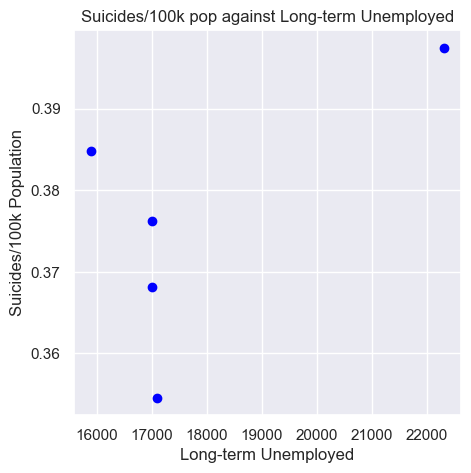

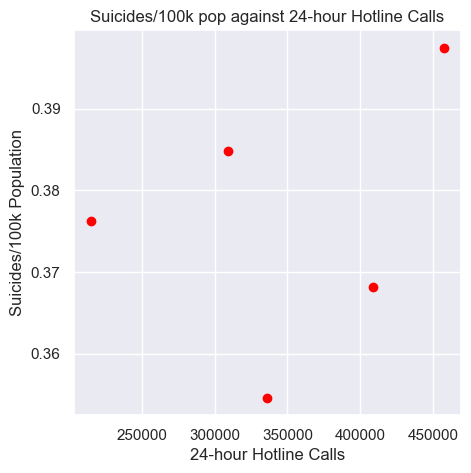

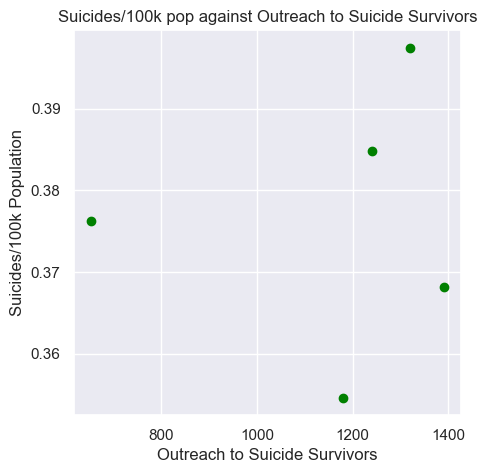

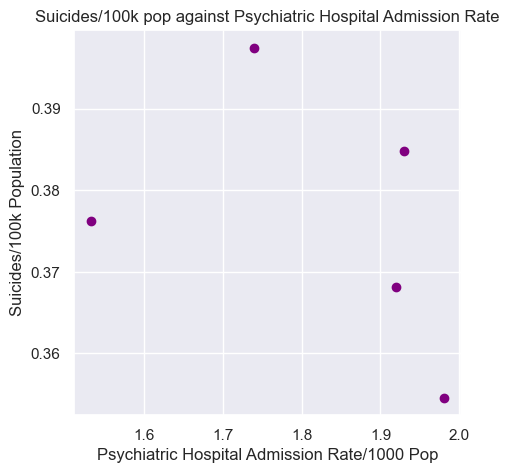

In [27]:
import matplotlib.pyplot as plt

# suicides/100k pop against long_term_unemployed
plt.figure(figsize=(5, 5))
plt.scatter(base['long_term_unemployed'], base['suicides/100k pop'], color='blue')
plt.title('Suicides/100k pop against Long-term Unemployed')
plt.xlabel('Long-term Unemployed')
plt.ylabel('Suicides/100k Population')
plt.show()

# suicides/100k pop against 24-hour hotline
plt.figure(figsize=(5, 5))
plt.scatter(base['24-hour Hotline'], base['suicides/100k pop'], color='red')
plt.title('Suicides/100k pop against 24-hour Hotline Calls')
plt.xlabel('24-hour Hotline Calls')
plt.ylabel('Suicides/100k Population')
plt.show()

# suicides/100k pop against outreach to suicide survivor
plt.figure(figsize=(5, 5))
plt.scatter(base['Outreach to Suicide Survivors'], base['suicides/100k pop'], color='green')
plt.title('Suicides/100k pop against Outreach to Suicide Survivors')
plt.xlabel('Outreach to Suicide Survivors')
plt.ylabel('Suicides/100k Population')
plt.show()

# suicides/100k pop against psychiatric hospital admission
plt.figure(figsize=(5, 5))
plt.scatter(base['psychiatric hospital admission rate/1000 pop'], base['suicides/100k pop'], color='purple')
plt.title('Suicides/100k pop against Psychiatric Hospital Admission Rate')
plt.xlabel('Psychiatric Hospital Admission Rate/1000 Pop')
plt.ylabel('Suicides/100k Population')
plt.show()

<Axes: >

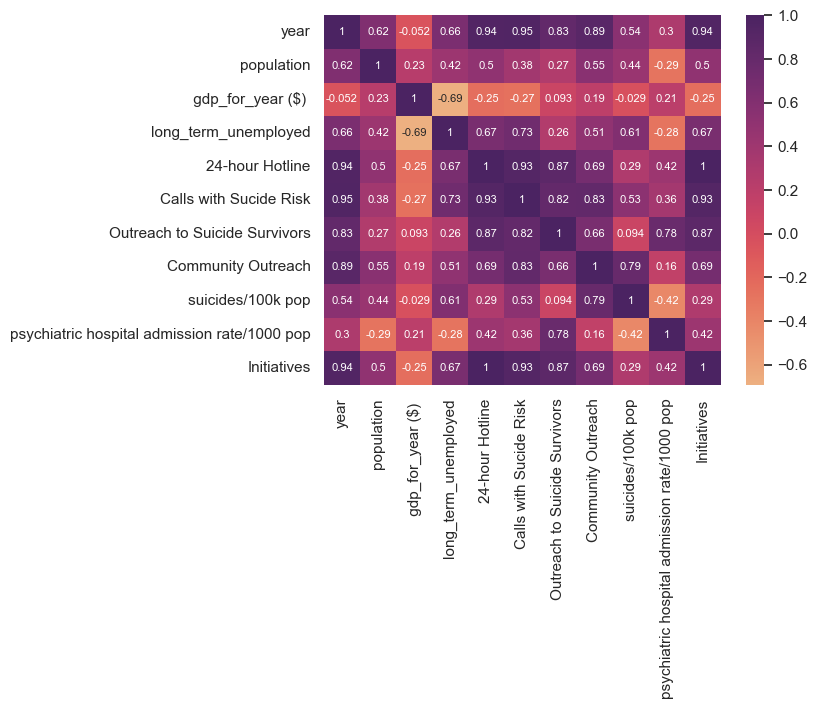

In [28]:
sns.heatmap(base.corr(), annot=True, annot_kws={"size": 8}, cmap='flare')

<Axes: >

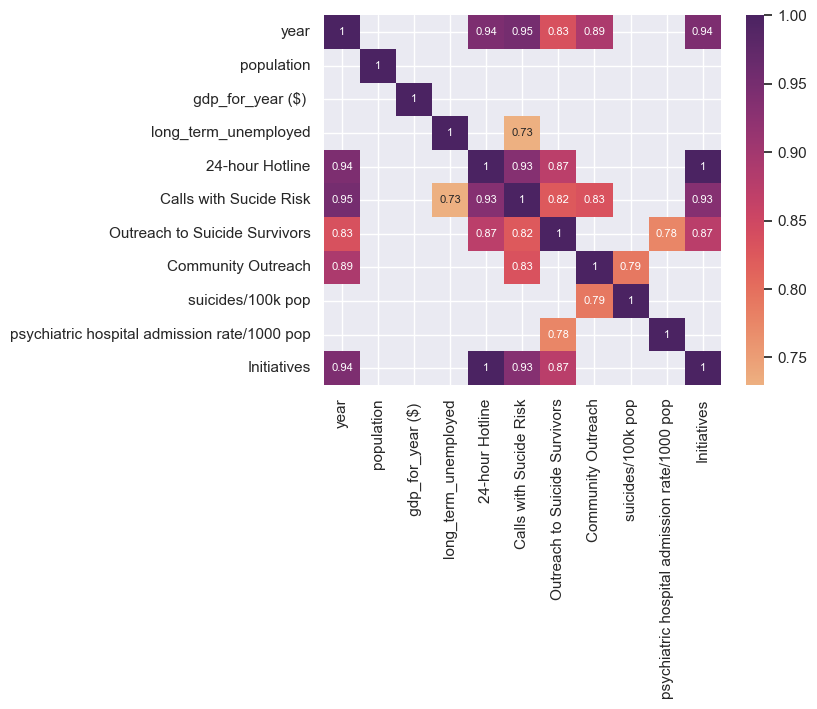

In [29]:
# threshold set at 0.70 to identify highest/lowest corr
mask = (np.abs(base.corr()) <= 0.7)

sns.heatmap(base.corr(), annot=True, annot_kws={"size": 8}, cmap='flare', mask=mask)

<p style="font-size: 15px;">
In the above analysis, the determinants showing significant positive correlation with suicide rates include year, calls with suicide risk, and community outreach. This pattern indicates that as these factors increase, there is a corresponding rise in suicide rates. However, this correlation should not be interpreted as direct causation as it is equally plausible that an rise in suicide rates may lead to enhanced social support measures, evidenced in the statistical data. There also seem to be a negative correlation with psychatric hospital admission. A negative correlation has been observed in relation to psychiatric hospital admissions, which may imply providing quality access to mental health care may be associated with a decrease in suicide rates. 

In [30]:
word_dictionary = {}

for word_freq_dict in processed_data:
    for word, count in word_freq_dict.items():
        if word not in filter_out:
            word_dictionary[word] = word_dictionary.get(word, 0) + count

sorted_word_dict = dict(sorted(word_dictionary.items(), key=lambda item: item[1], reverse=True))

In [31]:
sorted_word_dict

{'need': 42,
 'mental': 39,
 'people': 35,
 'health': 34,
 'take': 32,
 'suicide': 30,
 'thing': 30,
 'help': 30,
 'know': 29,
 'case': 29,
 'much': 27,
 'care': 26,
 'really': 26,
 'life': 26,
 'like': 25,
 'time': 23,
 'false': 21,
 'want': 20,
 'violence': 20,
 'support': 19,
 'good': 19,
 'student': 18,
 'everyone': 18,
 'feeling': 18,
 'sexual': 18,
 'family': 18,
 'post': 17,
 'told': 17,
 'year': 17,
 'still': 16,
 'friend': 16,
 'said': 16,
 'well': 15,
 'come': 15,
 'pretty': 15,
 'story': 15,
 'issue': 15,
 'someone': 15,
 'make': 15,
 'survivor': 15,
 'could': 15,
 'everything': 14,
 'tell': 14,
 'medium': 14,
 'anyone': 14,
 'professional': 13,
 'victim': 13,
 'think': 13,
 'death': 13,
 'school': 12,
 'police': 12,
 'feel': 12,
 'call': 12,
 'accusation': 12,
 'report': 12,
 'reason': 12,
 'plan': 12,
 'parent': 11,
 'hospital': 11,
 'medical': 11,
 'first': 11,
 'something': 11,
 'court': 11,
 'singaporean': 11,
 'social': 11,
 'talk': 10,
 'especially': 10,
 'last': 10,


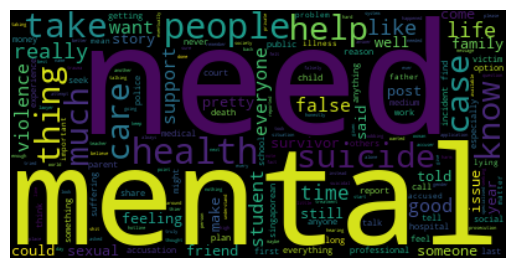

In [32]:
wcloud = WordCloud().generate_from_frequencies(sorted_word_dict)

plt.imshow(wcloud, interpolation='bilinear')
plt.axis('off')
(-1.5, 200, 100, -2.5)
plt.show()

##### **3.0 Results and Discussion**

##### **3.1 Key Findings**

<p style="font-size: 15px;">
So to break down the question, the major social determinants contributing to the increasing suicide rates in Singapore supported by the above data and logical reasoning is: 

<ul>
    <li style="font-size: 15px;"><b>Major historical events</b>: While the year itself is not a social determinant, it is important to consider the impact of significant events that occur over time e.g. covid-19 pandemic has adversely affected various social factors. Changes in employment patterns directly impacted income levels, subsequently altering ones' ability to meet basic needs and increasing financial stress—a known risk factor for suicide. The lockdowns imposed during the pandemic also restricted access to mental health support, exacerbating challenges such as increased isolation and intensifying feelings of loneliness. Additionally, the loss of lives due to the virus has contributed to heightened grief and trauma within communities. These factors when combined, significantly influence Singapore's societal health and any compromise in these areas can lead to detrimental effects on the overall mental well-being of the population, leaving many without needed support during a time of greater stress. <a href="#40-references-and-resources">[11]</a> The impact of the pandemic on social determinants has likely contributed to a surge in mental health crises, and only through understanding the indirect effects of historical events like this, policymakers and mental health organization can develop better intervention strategies.</li> 
    <li style="font-size: 15px;"><b>Inadequate community support</b>: The observed correlation data reveals an increase in suicide rates concurrent with heightened community outreach efforts, which suggests that Samaritans of Singapore has intensified its efforts to reduce suicide rates by expanding its reach through various events, campaigns, crisis hotlines, and referral initiatives to psychiatric hospitals, such as the Institute of Mental Health (IMH) which can then fall under 'psychiatric hospital admission'. This allows inference that community outreach plays a key role in providing quality mental health cafe from referral, which is potentially linked to a decrease in suicide rates. <a href="#40-references-and-resources">[12]</a> By proactively offering counseling and mental health services, especially during challenging times like the pandemic, Singapore-based organizations can help reduce the psychological impact of crises. However, to effectively manage the surge of calls related to suicide risk, it is essential to train additional personnel and volunteers in a professional setting to equip them with the skills needed to support individuals experiencing severe mental health obstacles that depend on these hotlines and organization as a final beacon of light.
    </li>    
    <li style="font-size: 15px;"><b>Unemployment</b>: As observed in the correlation table, calls with suicide risk show a high correlation with long-term unemployment rates, which suggest that as unemployment rates rise, potentially influenced by significant historical events in recent years, there is also a corresponding increase in calls related to suicide risk. Thus reflecting the psychological stress associated with the inability to provide for oneself, particularly during times of need. To significantly reduce the suicide risk present in distress calls, it is essential for Singapore government and the Samaritans of Singapore to collaborate effectively; their joint effort should focus on providing support targeted at reducing unemployment rates by a substantial margin of at least a 69.38% decrease. While it may appear challenging, gradual and steady efforts to reintegrate individuals back into the society can be implemented through practical training workshops, which would enable them to acquire newer technology and skills. Additionally, providing financial assistance to the unemployed can offer crucial support during this transition period. </li>
</ul> 

<p style="font-size: 15px;">
These frequently mentioned terms in Reddit discussions about the Samaritans of Singapore reflect a significant focus on mental well-being and the collective societal need for support. Common words like 'need', 'mental', 'people', and 'health' often accompany conversations of a grave nature, commonly relating to suicidal tendencies and these patterns indicates that mental health issues remain a predominant cause of suicidal risks, and organizations like the Samaritans of Singapore are pivotal in providing support in this domain. Expressions like 'support', 'friend', and 'care' accentuate the critical function of social support frameworks in a society where mental health is a growing concern. Moreover, mentions of 'survivor', 'sexual', and 'violence' suggest that individuals affected by such traumatic experiences might be soliciting or receiving assistance from the Samaritans of Singapore, which serves as a supportive mediator. 

<p style="font-size: 15px;">
Threads within these discussions likely explore the mental health support services and the community's response facilitated by entities like the Samaritans of Singapore, engaging in suicide prevention through various means, including a 24-hour hotline, educational outreach, and outreach to organizations and victims of crimes. This research also uncovers that unemployment contributes to an elevated risk of suicide, emphasizing the need for the Samaritans of Singapore to collaborate with governmental agencies as such efforts could focus on reintegrating the unemployed into society through workshops and programs that equip at-risk individuals with new skills. Nonetheless, the partnership should prioritize holistic strategies over merely ambitious quantitative objectives to counteract the psychological effects of unemployment with supportive policies and community initiatives, which has the potential to forge a more resilient society that can better manage the mental health challenges associated with these social determinants.

##### **3.2 Limitations**
<p style="font-size: 15px;">
Conducting research on a sensitive topic like suicide requires utmost respect for privacy and adherence to ethical considerations. This commitment, however, has led to challenges due to limited data availability as the scarcity of data has significantly constrained the scope of this study, diminishing the likelihood of reaching conclusions that accurately represent the majority of the deceased. Despite these obstacles, I found a meaningful direction for my research. My primary question focused on understanding the relationship between the Samaritans of Singapore's initiatives and the rising suicide rates, exploring how these elements interplay in the context of suicide prevention.

<p style="font-size: 15px;">
However, my approach was not without limitations and errors. One key issue was my choice of research question. By concentrating solely on correlation analysis between factors and the Samaritans of Singapore's efforts, I inadvertently limited the scope of potential analytical methods, such as statistical analyses, that could have provided a more comprehensive understanding had my question been broader. Additionally, my choice of the main dataset proved to be less than ideal. While it offered socioeconomic data, it lacked the specific social data crucial to my project. For instance, while GDP data hinted at economic factors not being central to suicide rates, the Human Development Index (HDI) data, which I anticipated would be rich in social factors like education and quality of life, was unexpectedly empty and this discovery during the data cleaning phase was a setback, as this data was provided by World Health Organization and integrated with other reliable sources to enhance the suicide rate information with additional socioeconomic factors up to 2021. Fortunately, by merging various datasets sourced from literature reviews and annual reports, I was able to salvage the project with critical statistics.

<p style="font-size: 15px;">
Lastly, the structure of my research question limited the scope for exploratory visualizations. The focus on correlation analysis between different variables meant that most of the insights could be gleaned from examining these relationships, leaving little room for more diverse or exploratory types of data visualization.

##### **3.3 Conclusion**
<p style="font-size: 15px;">
To summarize, the research investigates the repercussions of significant historical events, insufficient community support, and unemployment as the principal social factors driving the amplification of suicide rates in Singapore, which is why it's important for organizations like the Samaritans of Singapore to continue and enhance their community support endeavors, including outreach, skill workshops and psychiatric service referrals, to effectively meet these challenges.

<p style="font-size: 15px;">
[1] Channel NewsAsia. (2023, July 1). Suicides reported in Singapore reach 476 in 2022, highest in more than 20 years. <a href="https://cnalifestyle.channelnewsasia.com/singapore/suicides-reported-singapore-476-2022-highest-more-20-years-379536">Channel NewsAsia.</a>
</p>

<p style="font-size: 15px;">
[2] Seab, J. H. K., & Shim, K. J. (2018). Data mining approach to the detection of suicide in social media: A case study of Singapore. Proceedings of the 2018 IEEE International Conference on Big Data (Big Data), 5442-5444. <a href="https://ink.library.smu.edu.sg/cgi/viewcontent.cgi?article=5343&context=sis_research">SIS Research.</a>
</p>

<p style="font-size: 15px;">
[3] Samaritans of Singapore. (2022). Annual Report 2021-2022. <a href="https://www.sos.org.sg/media/annual-reports">Samaritans of Singapore.</a>
</p>

<p style="font-size: 15px;">
[4] Gowda, O. (2022). Suicide Rates Overview (1985 to 2021): Compares socio-economic info with suicide rates by year and country. Kaggle. <a href="https://www.kaggle.com/datasets/twinkle0705/mental-health-and-suicide-rates">Kaggle.</a>
</p>

<p style="font-size: 15px;">
[5] Creative Commons. (n.d.). CC0 1.0 Universal (CC0 1.0) Public Domain Dedication. Retrieved September 20, 2023, from <a href="https://creativecommons.org/public-domain/cc0/">Creative Commons.</a>
</p>

<p style="font-size: 15px;">
[6] Singapore Legal Advice. (2022, December 5). Defaming the Dead. SingaporeLegalAdvice.com. Retrieved December 5, 2023, from <a href="https://singaporelegaladvice.com/find-a-lawyer/services/defamation/">Singapore Legal Advice.</a>
</p>

<p style="font-size: 15px;">
[7] Boté-Vericad, J. J., & Termens, M. (2019). Reusing Data: Technical and Ethical Challenges. DESIDOC Journal of Library & Information Technology, 39(6), 329-337. <a href="https://pdfs.semanticscholar.org/24af/32d538d88f60468ab79a3f7666033423af95.pdf">DESIDOC Journal.</a>
</p>

<p style="font-size: 15px;">
[8] Blakely, T. A., Collings, S. C. D., & Atkinson, J. (2003). Unemployment and suicide. Evidence for a causal association? Journal of Epidemiology & Community Health, 57(8), 594-600. <a href="https://pubmed.ncbi.nlm.nih.gov/12883065/">Journal of Epidemiology & Community Health.</a>
</p>

<p style="font-size: 15px;">
[9] Reddit. (2023, December 10). What is fair use and where can I find out more about it? Reddit Help Rules & Reporting Copyright Help Center. Retrieved December 10, 2023, from <a href="https://www.reddit.com/r/editors/comments/12n274t/what_is_fair_use_and_what_isnt/">Reddit.</a>
</p>

<p style="font-size: 15px;">
[10] Brydon, M. (2021). Correlation and Scatterplots. <a href="https://infovis-wiki.net/wiki/Teaching:TUW_-UE_InfoVis_WS_2008/09-Gruppe_02-Aufgabe_1-_Scatterplot">InfoVis Wiki.</a>
</p>

<p style="font-size: 15px;">
[11] Hosseinzadeh, P., Zareipour, M., Baljani, E., & Moradali, M. R. (2022). Social Consequences of the COVID-19 Pandemic. A Systematic Review. Invest Educ Enferm, 40(1), e10. <a href="https://pubmed.ncbi.nlm.nih.gov/35485623/">PubMed.</a>
</p>

<p style="font-size: 15px;">
[12] Institute of Mental Health. (2021). Dealing with a Crisis. <a href="https://www.imh.com.sg/Mental-Health-Resources/Conditions-and-Challenges/Pages/Dealing-with-a-Crisis.aspx">IMH.</a>
</p>

<p style="font-size: 15px;">
Additional Resources:

<p style="font-size: 15px;">
Shaw, C. (2019, February 3). How to customize Seaborn Correlation Heatmaps. <a href="https://www.geeksforgeeks.org/how-to-create-a-seaborn-correlation-heatmap-in-python/">Medium.</a>
</p>

<p style="font-size: 15px;">
Tanner, G. (2019, January 5). Scraping Reddit data: How to scrape data from Reddit using the Python Reddit API Wrapper (PRAW). <a href="https://towardsdatascience.com/scraping-reddit-data-1c0af3040768">Towards Data Science.</a>
</p>

<p style="font-size: 15px;">
Praw Documentation: <a href="https://praw.readthedocs.io/">https://praw.readthedocs.io/</a>
</p>